In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error

In [3]:
data = pd.read_csv("GoldPrice(2013-2023).csv")
data

,Date,Price,Open,High,Low,Vol.,Change %
0,12/30/2022,"1,826.20","1,821.80","1,832.40","1,819.80",107.50K,0.01%
1,12/29/2022,"1,826.00","1,812.30","1,827.30","1,811.20",105.99K,0.56%
2,12/28/2022,"1,815.80","1,822.40","1,822.80","1,804.20",118.08K,-0.40%
3,12/27/2022,"1,823.10","1,808.20","1,841.90","1,808.00",159.62K,0.74%
4,12/26/2022,"1,809.70","1,805.80","1,811.95","1,805.55",NaN,0.30%
...,...,...,...,...,...,...,...
2578,01/08/2013,"1,663.20","1,651.50","1,662.60","1,648.80",0.13K,0.97%
2579,01/07/2013,"1,647.20","1,657.30","1,663.80","1,645.30",0.09K,-0.16%
2580,01/04/2013,"1,649.90","1,664.40","1,664.40","1,630.00",0.31K,-1.53%
2581,01/03/2013,"1,675.60","1,688.00","1,689.30","1,664.30",0.19K,-0.85%


In [4]:
data['Date'] = pd.to_datetime(data['Date'], format='%m/%d/%Y')
data = data.sort_values('Date')

In [5]:
data['Price'] = data['Price'].replace(',', '', regex=True).astype(float)
data = data.set_index('Date')

In [6]:
ts = data['Price']

In [7]:
result = adfuller(ts.dropna())
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:', result[4])

ADF Statistic: -0.9779171167137418
p-value: 0.7612330831178808
Critical Values: {'1%': np.float64(-3.432892070219288), '5%': np.float64(-2.86266308749922), '10%': np.float64(-2.5673678605335093)}


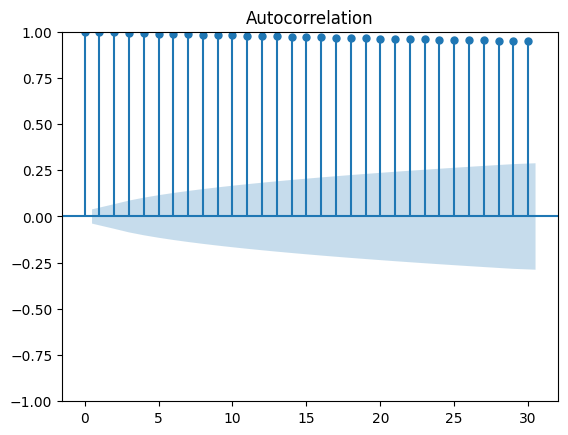

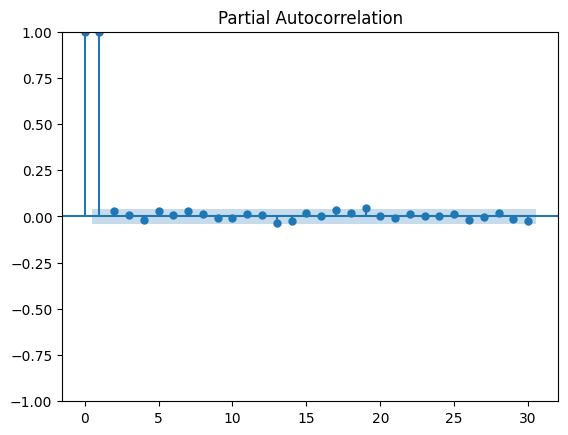

In [8]:
plot_acf(ts.dropna(), lags=30)
plot_pacf(ts.dropna(), lags=30)
plt.show()

In [9]:
train_size = int(len(ts) * 0.8)
train, test = ts[0:train_size], ts[train_size:]

In [10]:
lags = min(5, len(train) - 1)   # Ensure lags < training size
model = AutoReg(train, lags=lags).fit()
print(model.summary())

                            AutoReg Model Results                             
Dep. Variable:                  Price   No. Observations:                 2066
Model:                     AutoReg(5)   Log Likelihood               -8354.066
Method:               Conditional MLE   S.D. of innovations             13.936
Date:                Tue, 07 Oct 2025   AIC                          16722.132
Time:                        13:46:35   BIC                          16761.549
Sample:                             5   HQIC                         16736.583
                                 2066                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.1707      2.097      0.558      0.577      -2.940       5.282
Price.L1       0.9750      0.022     44.179      0.000       0.932       1.018
Price.L2       0.0471      0.031      1.528      0.1

c:\Users\admin\.conda\envs\DL\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [11]:
preds = model.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
preds.index = test.index

c:\Users\admin\.conda\envs\DL\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\admin\.conda\envs\DL\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\admin\.conda\envs\DL\Lib\site-packages\statsmodels\tsa\deterministic.py:308: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)


In [12]:
error = mean_squared_error(test, preds)
print("MSE:", round(error, 2))

MSE: 11466.13


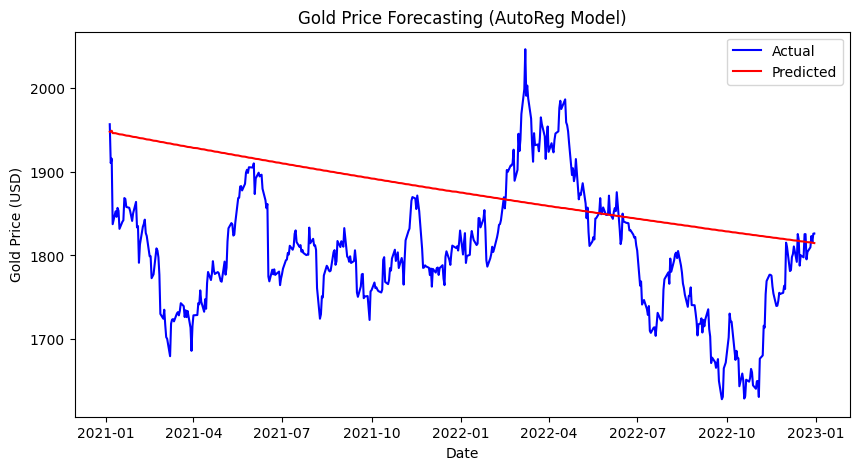

In [13]:
plt.figure(figsize=(10,5))
plt.plot(test.index, test, label='Actual', color='blue')
plt.plot(test.index, preds, label='Predicted', color='red')
plt.title("Gold Price Forecasting (AutoReg Model)")
plt.xlabel("Date")
plt.ylabel("Gold Price (USD)")
plt.legend()
plt.show()